In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
import plotly.express as px

In [156]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [157]:
%cd /content/drive/Shareddrives/Data606_Energy/data/futures

/content/drive/Shareddrives/Data606_Energy/data/futures


In [158]:
data = pd.read_csv('futures_data.csv')

In [159]:
# convert the date column into datetime index
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')

In [160]:
data.head()

,Date,Mean Movement Daily BZ=F,Std Movement Daily BZ=F,Mean Volume Daily BZ=F,Std Volume Daily BZ=F,Mean Movement Weekly BZ=F,Std Movement Weekly BZ=F,Mean Volume Weekly BZ=F,Std Volume Weekly BZ=F,Mean Movement Daily NG=F,Std Movement Daily NG=F,Mean Volume Daily NG=F,Std Volume Daily NG=F,Mean Movement Weekly NG=F,Std Movement Weekly NG=F,Mean Volume Weekly NG=F,Std Volume Weekly NG=F,Mean Movement Daily CL=F,Std Movement Daily CL=F,Mean Volume Daily CL=F,Std Volume Daily CL=F,Mean Movement Weekly CL=F,Std Movement Weekly CL=F,Mean Volume Weekly CL=F,Std Volume Weekly CL=F,Mean Movement Daily HO=F,Std Movement Daily HO=F,Mean Volume Daily HO=F,Std Volume Daily HO=F,Mean Movement Weekly HO=F,Std Movement Weekly HO=F,Mean Volume Weekly HO=F,Std Volume Weekly HO=F
0,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
data.shape

(264, 33)

In [162]:
data_standardized = data.copy()
period = 12
for col in data.columns:
  if 'Date' not in col:
    data_standardized[col+' Standardized'] = (data_standardized[col]-data_standardized[col].rolling(period).mean())/data_standardized[col].rolling(period).std()
    del data_standardized[col]

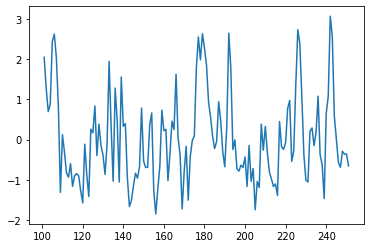

In [169]:
plt.plot(data_standardized['Mean Movement Daily BZ=F Standardized'])

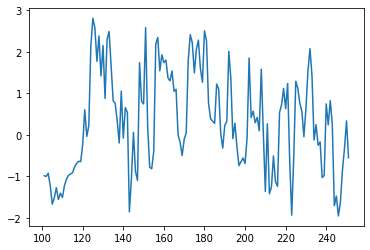

In [ ]:
plt.plot(data_standardized['Mean Volume Daily BZ=F Standardized'])

In [163]:
data_standardized.shape

(264, 33)

In [164]:
# function to combine the columns that are the same but have different futures. ex. combine "Mean Movement Daily" columns across all future symbols
def append_like_columns(data,col_name):
  return_list = []
  return_label = []
  return_ticker = []
  for col in data.columns:
    if col_name in col:
      return_list += list(data[col])
      return_label += list(data['Date'])
      if 'BZ=F' in col:
        return_ticker += [0]*data.shape[0]
      elif 'NG=F' in col:
        return_ticker += [1]*data.shape[0]
      elif 'CL=F' in col:
        return_ticker += [2]*data.shape[0]
      else:
        return_ticker += [3]*data.shape[0]
  return (return_list,return_label,return_ticker)

In [165]:
def combine_tickers(input_data, time_frame):
  output_list, output_labels, tickers = append_like_columns(input_data.copy(),'Mean Volume '+time_frame)
  avg_volume = pd.Series(output_list,index=output_labels,name='Mean Volume '+time_frame)
  output_list, output_labels, tickers = append_like_columns(input_data.copy(),'Mean Movement '+time_frame)
  avg_movement = pd.Series(output_list,index=output_labels,name='Mean Movement '+time_frame)
  output_list, output_labels, tickers = append_like_columns(input_data.copy(),'Std Volume '+time_frame)
  std_volume = pd.Series(output_list,index=output_labels,name='Std Volume '+time_frame)
  output_list, output_labels, tickers = append_like_columns(input_data.copy(),'Std Movement '+time_frame)
  std_movement = pd.Series(output_list,index=output_labels,name='Std Movement '+time_frame)
  combined = pd.DataFrame({'Tickers':tickers,'Mean Volume '+time_frame:avg_volume,'Mean Movement '+time_frame:avg_movement,'Std Volume '+time_frame:std_volume,'Std Movement '+time_frame:std_movement})
  combined['Volume CV'] = combined['Std Volume '+time_frame]/combined['Mean Volume '+time_frame]
  combined['Movement CV'] = combined['Std Movement '+time_frame]/combined['Mean Movement '+time_frame]
  return combined

In [166]:
daily_combined = combine_tickers(data_standardized, 'Daily')
weekly_combined = combine_tickers(data_standardized, 'Weekly')
# daily_combined = combine_tickers(data, 'Daily')
# weekly_combined = combine_tickers(data, 'Weekly')

In [167]:
daily_combined.corr()

,Tickers,Mean Volume Daily,Mean Movement Daily,Std Volume Daily,Std Movement Daily,Volume CV,Movement CV
Tickers,1.000000,-0.017025,-0.018582,-0.018682,-0.000606,-0.014184,-0.007238
Mean Volume Daily,-0.017025,1.000000,0.260572,0.607592,0.191440,-0.006970,-0.025552
Mean Movement Daily,-0.018582,0.260572,1.000000,0.260978,0.817711,-0.014772,-0.000530
Std Volume Daily,-0.018682,0.607592,0.260978,1.000000,0.304349,0.062259,-0.016182
Std Movement Daily,-0.000606,0.191440,0.817711,0.304349,1.000000,0.007042,0.003667
Volume CV,-0.014184,-0.006970,-0.014772,0.062259,0.007042,1.000000,-0.000193
Movement CV,-0.007238,-0.025552,-0.000530,-0.016182,0.003667,-0.000193,1.000000


In [168]:
weekly_combined.corr()

,Tickers,Mean Volume Weekly,Mean Movement Weekly,Std Volume Weekly,Std Movement Weekly,Volume CV,Movement CV
Tickers,1.000000,-0.018317,-0.023318,-0.022763,-0.014990,-0.038229,-0.064281
Mean Volume Weekly,-0.018317,1.000000,0.242557,0.319649,0.168333,0.016289,0.039749
Mean Movement Weekly,-0.023318,0.242557,1.000000,0.189925,0.702499,0.015356,0.000822
Std Volume Weekly,-0.022763,0.319649,0.189925,1.000000,0.244314,-0.024456,0.036616
Std Movement Weekly,-0.014990,0.168333,0.702499,0.244314,1.000000,-0.030901,-0.024643
Volume CV,-0.038229,0.016289,0.015356,-0.024456,-0.030901,1.000000,0.032293
Movement CV,-0.064281,0.039749,0.000822,0.036616,-0.024643,0.032293,1.000000


In [103]:
daily_combined.head()

,Tickers,Mean Volume Daily,Mean Movement Daily,Std Volume Daily,Std Movement Daily,Volume CV,Movement CV
2000-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,0,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,0,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
daily_combined.index.strftime('%Y-%m-%d')[0]

'2000-01-01'

In [140]:
ticker = 1
condition = (daily_combined['Tickers']==ticker) & (daily_combined.index>=datetime(year=2015,month=1,day=1))
fig = px.scatter(x=daily_combined['Mean Volume Daily'][condition], y=daily_combined['Mean Movement Daily'][condition], 
                 hover_data=[list(daily_combined.index[condition].strftime('%Y-%m-%d'))], width=800, height=600, 
                 title = "Impact of Volume of Futures Contracts Traded\nOn Price Volatility",
                 labels = {'x':'Mean Daily Volume per  Month',
                           'y':'Mean Daily Price Movement per Month (%)'})
fig.show()
#plt.scatter(daily_combined['Mean Volume Daily'][condition],daily_combined['Mean Movement Daily'][condition],c=daily_combined['Tickers'][condition],s=1)

In [120]:
daily_combined[['Mean Volume Daily','Mean Movement Daily']][condition].corr()

,Mean Volume Daily,Mean Movement Daily
Mean Volume Daily,1.000000,0.384342
Mean Movement Daily,0.384342,1.000000


In [121]:

daily_combined[:][condition].corr()

,Tickers,Mean Volume Daily,Mean Movement Daily,Std Volume Daily,Std Movement Daily,Volume CV,Movement CV
Tickers,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean Volume Daily,NaN,1.000000,0.384342,0.883755,0.393897,0.321392,0.226178
Mean Movement Daily,NaN,0.384342,1.000000,0.450657,0.834528,0.328501,0.312087
Std Volume Daily,NaN,0.883755,0.450657,1.000000,0.533659,0.718164,0.354443
Std Movement Daily,NaN,0.393897,0.834528,0.533659,1.000000,0.448559,0.745595
Volume CV,NaN,0.321392,0.328501,0.718164,0.448559,1.000000,0.349609
Movement CV,NaN,0.226178,0.312087,0.354443,0.745595,0.349609,1.000000


In [122]:
ticker = 2
condition = (weekly_combined['Tickers']==ticker) & (weekly_combined.index>=datetime(year=2015,month=1,day=1))
weekly_combined[:][condition].corr()

,Tickers,Mean Volume Weekly,Mean Movement Weekly,Std Volume Weekly,Std Movement Weekly,Volume CV,Movement CV
Tickers,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean Volume Weekly,NaN,1.000000,0.157418,0.523548,0.171187,-0.100769,0.168486
Mean Movement Weekly,NaN,0.157418,1.000000,0.273168,0.972277,0.152967,0.714548
Std Volume Weekly,NaN,0.523548,0.273168,1.000000,0.294717,0.762861,0.494133
Std Movement Weekly,NaN,0.171187,0.972277,0.294717,1.000000,0.165793,0.757122
Volume CV,NaN,-0.100769,0.152967,0.762861,0.165793,1.000000,0.426566
Movement CV,NaN,0.168486,0.714548,0.494133,0.757122,0.426566,1.000000


In [142]:
ticker = 1
condition = (weekly_combined['Tickers']==ticker)# & (weekly_combined.index>=datetime(year=2015,month=1,day=1))
fig = px.scatter(x=weekly_combined['Volume CV'][condition], y=weekly_combined['Movement CV'][condition], 
                 hover_data=[list(weekly_combined.index[condition].strftime('%Y-%m-%d'))], width=800, height=600, 
                 title = "Impact of Volume of Futures Contracts Traded\nOn Price Volatility",
                 labels = {'x':'Mean Daily Volume per  Month',
                           'y':'Mean Daily Price Movement per Month (%)'})
fig.show()

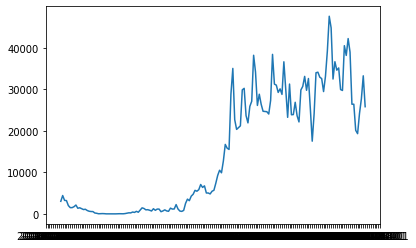

In [89]:
plt.plot(daily_combined['Mean Volume Daily'][daily_combined['Tickers']==ticker])

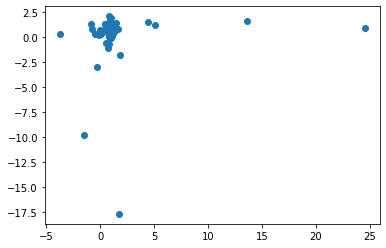

In [ ]:
plt.scatter(weekly_combined['Volume CV'],weekly_combined['Movement CV'])

In [ ]:
output_list, output_labels = append_like_columns(data_standardized.copy(),'Mean Volume Weekly')
daily_avg_volume = pd.Series(output_list,index=output_labels,name='Mean Volume Weekly')
output_list, output_labels = append_like_columns(data_standardized.copy(),'Mean Movement Weekly')
daily_avg_movement = pd.Series(output_list,index=output_labels,name='Mean Movement Weekly')
output_list, output_labels = append_like_columns(data_standardized.copy(),'Std Volume Weekly')
daily_std_volume = pd.Series(output_list,index=output_labels,name='Std Volume Weekly')
output_list, output_labels = append_like_columns(data_standardized.copy(),'Std Movement Weekly')
daily_std_movement = pd.Series(output_list,index=output_labels,name='Std Movement Weekly')
weekly_combined = pd.DataFrame({'Mean Volume Weekly':daily_avg_volume,'Mean Movement Weekly':daily_avg_movement,'Std Volume Weekly':daily_std_volume,'Std Movement Weekly':daily_std_movement})

In [ ]:
daily_avg_volume.corr(daily_avg_movement)

-0.020210101764237442

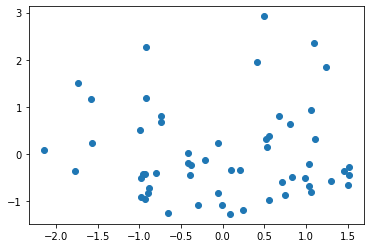

In [ ]:
plt.scatter(daily_avg_volume,daily_avg_movement)

In [ ]:
daily_avg_volume.corr(daily_avg_movement)

-0.020210101764237442

In [ ]:
# make a dataframe with only the daily stuff
daily_cols = []
for col in data_standardized.columns:
  if 'Daily' in col:
    daily_cols.append(col)
daily_data_standardized = data_standardized[daily_cols]

# make a dataframe with only the weekly stuff
weekly_cols = []
for col in data_standardized.columns:
  if 'Weekly' in col:
    weekly_cols.append(col)
weekly_data_standardized = data_standardized[weekly_cols]

# make a dataframe with only the daily stuff
monthly_cols = []
for col in data_standardized.columns:
  if 'Monthly' in col:
    monthly_cols.append(col)
monthly_data_standardized = data_standardized[monthly_cols]

In [ ]:
pd.options.display.max_colwidth = 40

In [ ]:
pd.options.display.max_rowheight

OptionError: ignored

In [ ]:
daily_data_standardized.corr()

,Mean Movement Daily BZ=F Standardized,Std Movement Daily BZ=F Standardized,Mean Volume Daily BZ=F Standardized,Std Volume Daily BZ=F Standardized,Mean Movement Daily NG=F Standardized,Std Movement Daily NG=F Standardized,Mean Volume Daily NG=F Standardized,Std Volume Daily NG=F Standardized,Mean Movement Daily CL=F Standardized,Std Movement Daily CL=F Standardized,Mean Volume Daily CL=F Standardized,Std Volume Daily CL=F Standardized,Mean Movement Daily HO=F Standardized,Std Movement Daily HO=F Standardized,Mean Volume Daily HO=F Standardized,Std Volume Daily HO=F Standardized
Mean Movement Daily BZ=F Standardized,1.000000,0.888213,0.485843,0.519817,0.539741,0.364400,0.127527,0.135135,0.927978,0.712937,0.335877,0.559238,0.904189,0.933528,-0.030224,0.283213
Std Movement Daily BZ=F Standardized,0.888213,1.000000,0.453571,0.522595,0.593274,0.455095,0.330936,0.365769,0.888509,0.936906,0.278515,0.649887,0.769160,0.950761,0.116387,0.444603
Mean Volume Daily BZ=F Standardized,0.485843,0.453571,1.000000,0.993135,-0.174858,0.066833,0.710894,0.734671,0.207690,0.310822,0.890956,0.885196,0.139367,0.267336,0.688252,0.853868
Std Volume Daily BZ=F Standardized,0.519817,0.522595,0.993135,1.000000,-0.131852,0.117197,0.723600,0.755121,0.249864,0.390434,0.855417,0.896753,0.164891,0.328099,0.693164,0.875774
Mean Movement Daily NG=F Standardized,0.539741,0.593274,-0.174858,-0.131852,1.000000,0.674355,-0.221536,-0.127420,0.755072,0.568417,-0.244307,0.027199,0.748143,0.715251,-0.456671,-0.226894
Std Movement Daily NG=F Standardized,0.364400,0.455095,0.066833,0.117197,0.674355,1.000000,-0.032432,0.247195,0.462107,0.422861,-0.035683,0.152707,0.393001,0.471739,-0.130491,0.077645
Mean Volume Daily NG=F Standardized,0.127527,0.330936,0.710894,0.723600,-0.221536,-0.032432,1.000000,0.918029,-0.005570,0.315076,0.702207,0.758777,-0.159339,0.087852,0.932423,0.932232
Std Volume Daily NG=F Standardized,0.135135,0.365769,0.734671,0.755121,-0.127420,0.247195,0.918029,1.000000,0.021913,0.355903,0.701436,0.778273,-0.139467,0.112920,0.827117,0.901337
Mean Movement Daily CL=F Standardized,0.927978,0.888509,0.207690,0.249864,0.755072,0.462107,-0.005570,0.021913,1.000000,0.767710,0.092262,0.384886,0.962839,0.977288,-0.228609,0.082451
Std Movement Daily CL=F Standardized,0.712937,0.936906,0.310822,0.390434,0.568417,0.422861,0.315076,0.355903,0.767710,1.000000,0.136519,0.584853,0.602928,0.844974,0.082223,0.399541


In [ ]:
# create a list of the standardized average daily volumes and standardized daily  average price movements
daily_avg_volumes = []
daily_avg_movements = []
for col in data_standardized.columns:
  if 'Mean Volume Daily' in col:
    daily_avg_volumes += list(data_standardized[col])
  elif 'Mean Movement Daily' in col:
    daily_avg_

In [ ]:
# create a list of the standardized average volumes and standardized daily average price movement
stand_avg_daily_volume = []
stand_avg_daily_movement = []
daily_volume_symbols = []
volume_years = []
daily_movement_symbols = []
movement_years = []
for col in data.columns:
  if 'Daily' in col and 'Volume' in col:
    daily_volume_symbols += [col[-4:]]*data.shape[0]
    stand_avg_daily_volume += list((data[col] - data[col].mean())/data[col].std())
    volume_years += list(data['Year'])
  elif 'Daily' in col and 'Movement' in col:
    daily_movement_symbols += [col[-4:]]*data.shape[0]
    stand_avg_daily_movement += list((data[col] - data[col].mean())/data[col].std())
    movement_years += list(data['Year'])
volume_df = pd.DataFrame({'Daily Average Volume':stand_avg_daily_volume,'Volume Symbol':daily_volume_symbols},index=volume_years)
movement_df = pd.DataFrame({'Daily Average Movement':stand_avg_daily_movement,'Movement Symbol':daily_movement_symbols},index=movement_years)
daily_df = pd.merge(volume_df,movement_df,left_index=True, right_index=True)

In [ ]:
daily_df.shape

(896, 4)

In [ ]:
# look at the relationship between average daily volume and daily average price movement
# standardize the volume columns

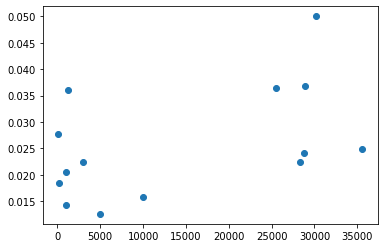

In [ ]:
plt.scatter(data['Mean Volume Daily BZ=F'],data['Mean Movement Daily BZ=F'])